In [335]:
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

## Load data

In [336]:
current_dir = os.getcwd()
path = os.path.join(current_dir, '../data/clean', "merged_dataset_1.csv")
df = pd.read_csv(path)

## Select year

In [337]:
# df = df[df["Year"] == 2012].copy()
# len(df)

In [338]:
cols_to_drop = [
    'Well_ID', 'BRO-ID', 'geometry', 'Filter', 'Date', 'distance_m',
    'Unnamed: 0', 'Total Livestock', 'Excretion during grazing (million kg)', 'Municipal waste (1000 tonnes)/Total municipal waste (1 000 tonnes)',
    'Nitrogen losses in housing and storages/Total nitrogen losses (N) (million kg)',
    'Use of livestock manure in agriculture (million kg)', 'Mineral fertiliser N/ha in kg'
]

df = df.drop(columns=cols_to_drop, errors="ignore")

In [339]:
df['Landuse_Code'] = df['Landuse_Code'].fillna(-1).astype(int)

df['HGRnaam'] = df['HGRnaam'].astype("category")
df['Landuse_Code'] = df['Landuse_Code'].astype("category")

In [340]:
df = df.dropna()
len(df)

191

## Remove nitrate outliers

<Axes: >

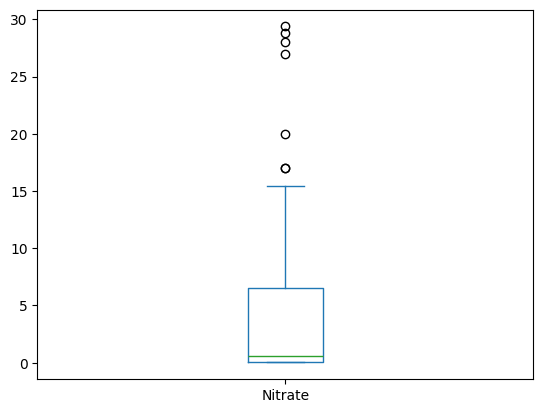

In [341]:
df[["Nitrate"]].plot(kind = "box")

In [342]:
q1 = df["Nitrate"].quantile(0.25)
q3 = df["Nitrate"].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df[(df["Nitrate"] < lower_bound) | (df["Nitrate"] > upper_bound)]
print(f"Outliers found: {len(outliers)}")
outliers

Outliers found: 7


,Nitrate,avg_depth_m,Year,Population,HGRnaam,Landuse_Code,avg_temp_mean,avg_precip_sum,lon,lat,Elevation_m
54,28.79,5.087486,2012,65.0,zand,26,34.000000,1.50,5.441417,52.007418,8.548440
55,28.00,4.858125,2015,65.0,zand,-1,126.333333,6.50,5.441417,52.007418,8.548440
56,27.00,5.061042,2018,65.0,zand,23,122.883333,2.00,5.441417,52.007418,8.548440
70,29.37,6.838178,2012,40.0,zand,11,29.466667,8.75,5.600794,51.962454,12.048532
71,20.00,6.634271,2015,35.0,zand,-1,125.166667,1.00,5.600794,51.962454,12.048532
72,17.00,6.654944,2018,40.0,zand,27,115.566667,0.25,5.600794,51.962454,12.048532
78,17.00,9.291444,2018,55.0,zand,27,137.700000,6.00,5.546524,51.966980,16.680454


In [343]:
# top_nitrate_outliers = list(df["Nitrate"].sort_values()[-len(outliers):].index)
# top_nitrate_outliers
# df = df.drop(top_nitrate_outliers)
# len(df)

## Preprocess data

In [344]:
categorical_cols = ["HGRnaam", "Landuse_Code"]
numerical_cols = [col for col in df.columns if col not in categorical_cols + ["Nitrate"]]

In [345]:
preprocessor = ColumnTransformer([
    ("cat_ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols)
], remainder="passthrough")

In [346]:
rf_model = RandomForestRegressor(random_state=4, oob_score=True)

In [347]:
pipe = Pipeline([
    ("prep", preprocessor),
    ("rf", RandomForestRegressor(oob_score=True, random_state=4))
])

In [348]:
X = df[categorical_cols + numerical_cols]

y = df["Nitrate"].values

## Test / train split

In [349]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27)

In [350]:
param_grid = {
    "rf__n_estimators": [100, 150],
    "rf__max_features": ["sqrt", 0.5],
    "rf__max_depth": [None, 10],
    "rf__min_samples_split": [2, 4],
    "rf__min_samples_leaf": [1, 2]
}

In [351]:
search = RandomizedSearchCV(
    pipe,
    param_distributions=param_grid,
    n_iter=30,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    random_state=9,
    verbose=1
)

In [352]:
search.fit(X_train, y_train)
pred_nitrate = search.predict(X_test)

print("Best CV R2:", search.best_score_)
print("Best params:", search.best_params_)
print("OOB score:", search.best_estimator_.named_steps["rf"].oob_score_)
print("Test R2:", r2_score(y_test,  pred_nitrate))
print("Test MAE:",mean_absolute_error(y_test, pred_nitrate))
print("Test MSE:", mean_squared_error(y_test, pred_nitrate))

Fitting 5 folds for each of 30 candidates, totalling 150 fits


Best CV R2: 0.6202103866813335
Best params: {'rf__n_estimators': 150, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 2, 'rf__max_features': 0.5, 'rf__max_depth': None}
OOB score: 0.6809278634710252
Test   R2: 0.8393749078140809
Test   MAE: 1.4963866493506497
Test   MSE: 5.6353010206374705


## Real vs Predicted

<Axes: >

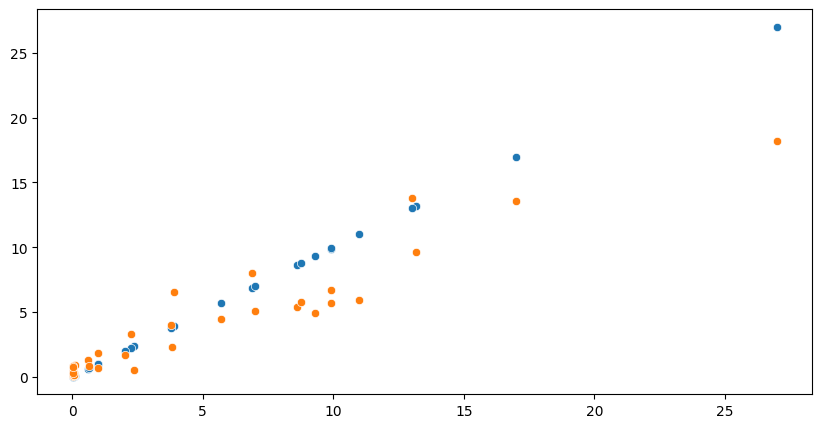

In [353]:
fix, ax = plt.subplots(figsize= (10,5))

sns.scatterplot(x = y_test, y = y_test, ax = ax)
sns.scatterplot(x = y_test, y = pred_nitrate, ax = ax)

## Residuals

Text(0, 0.5, 'Residuals')

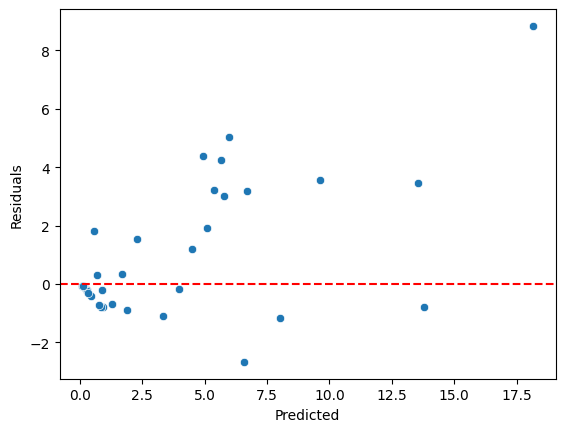

In [354]:
preds = search.predict(X_test)
residuals = y_test - preds
sns.scatterplot(x=preds, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted"); plt.ylabel("Residuals")

## Feature importances

--> Gain (by default) how much each feature, on average, reduces the impurity (MSE or Gini)

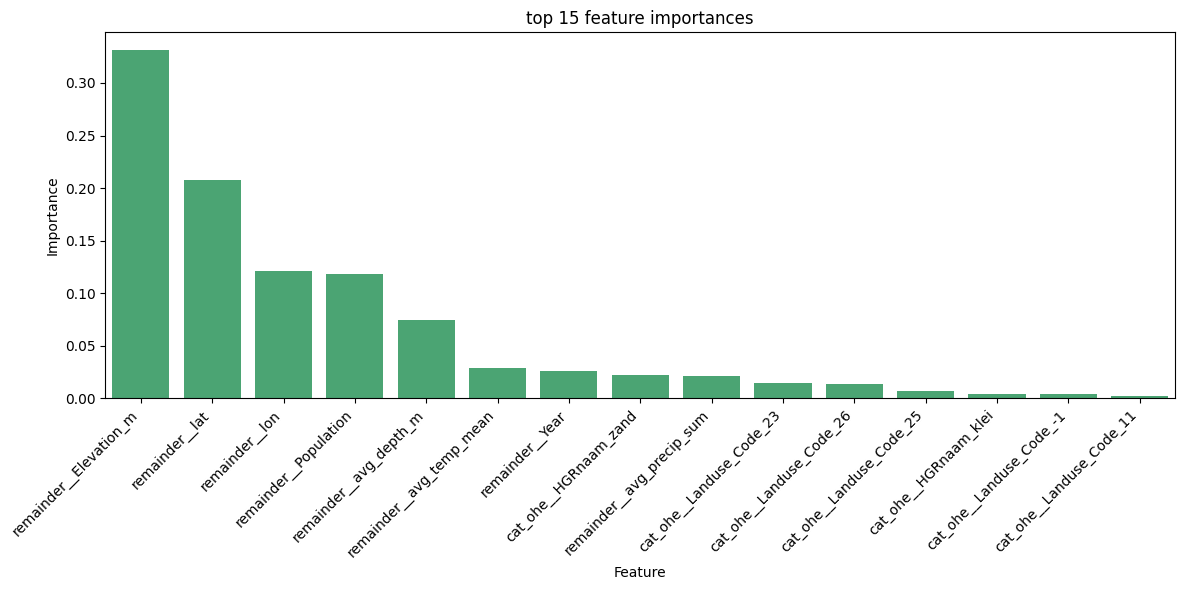

In [357]:
best_pipe = search.best_estimator_

feature_names = best_pipe.named_steps["prep"].get_feature_names_out()

rf_model = best_pipe.named_steps["rf"]
importances = rf_model.feature_importances_

fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

# plt.figure(figsize=(10, 6))
# sns.barplot(x="Importance", y="Feature", data=fi_df.head(15))
# plt.title("top 15 feature importances")
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x="Feature", y="Importance", data=fi_df.head(15), color="mediumseagreen")
plt.xticks(rotation=45, ha='right')
plt.title("top 15 feature importances")
plt.tight_layout()
plt.show()